## Import

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import pathlib
from typing import Any,Union   

2022-10-05 08:56:59.650889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 08:57:00.421101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-05 08:57:00.421157: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-05 08:57:00.515363: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 08:57:02.644919: W tensorflow/stream_executor/platform/de

In [2]:
print(tf.config.experimental.list_physical_devices())
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
True


2022-10-05 08:57:05.535959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-05 08:57:05.536436: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-05 08:57:05.536463: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Kali): /proc/driver/nvidia/version does not exist


## Def

In [3]:
BATCH_SIZE:int  = 64
IMG_HEIGHT:int  = 227
IMG_WIDTH:int   = 227

# Valdiate 20% 
VAL_SPLIT:float = 0.2

model = {}


In [4]:
def get_dataset_dir(path) -> str:
    return pathlib.Path(path)

In [5]:
def load_dataset(dir) -> Union[list | Any, list | Any]:
  train_ds = tf.keras.utils.image_dataset_from_directory(
    dir,
    validation_split=VAL_SPLIT,
    label_mode='binary',
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)
  val_ds = tf.keras.utils.image_dataset_from_directory(
    dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    label_mode='binary',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)
  return train_ds, val_ds

In [6]:
def print_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Sketch

### Load Dataset

In [7]:
data_dir:str = get_dataset_dir('data_multi_binary/train/sketch')

train_ds, val_ds = load_dataset(data_dir)
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

# Load datasets in cache to optimize 
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 198 files belonging to 2 classes.
Using 159 files for training.
Found 198 files belonging to 2 classes.
Using 39 files for validation.


2022-10-05 08:57:05.770328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model and Train

In [8]:
EPOCHS=15

with tf.device('/GPU:0'):
    # Def model
    model['sketch'] = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Feature extraction
        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        # Deep NN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Compile model
    model['sketch'].compile(optimizer='adamax', # or adam
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    
    # model.summary()
    
    checkpoint_filepath = '/tmp/checkpoint/sketch'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


    history:tf.keras.callbacks.History = model['sketch'].fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=model_checkpoint_callback
    )
    model['sketch'].load_weights(checkpoint_filepath)


Epoch 1/15
3/3 [==============================] - 10s 4s/step - loss: 2.4993 - accuracy: 0.5346 - val_loss: 0.9971 - val_accuracy: 0.5128
Epoch 2/15
3/3 [==============================] - 8s 3s/step - loss: 0.8041 - accuracy: 0.5409 - val_loss: 0.7614 - val_accuracy: 0.4872
Epoch 3/15
3/3 [==============================] - 8s 2s/step - loss: 0.7365 - accuracy: 0.5220 - val_loss: 0.6884 - val_accuracy: 0.4872
Epoch 4/15
3/3 [==============================] - 8s 2s/step - loss: 0.6711 - accuracy: 0.5597 - val_loss: 0.6596 - val_accuracy: 0.4872
Epoch 5/15
3/3 [==============================] - 9s 4s/step - loss: 0.6291 - accuracy: 0.5849 - val_loss: 0.6114 - val_accuracy: 0.7179
Epoch 6/15
3/3 [==============================] - 9s 4s/step - loss: 0.5692 - accuracy: 0.6918 - val_loss: 0.5365 - val_accuracy: 0.8718
Epoch 7/15
3/3 [==============================] - 9s 3s/step - loss: 0.5172 - accuracy: 0.7296 - val_loss: 0.4405 - val_accuracy: 0.9231
Epoch 8/15
3/3 [========================

### Validate

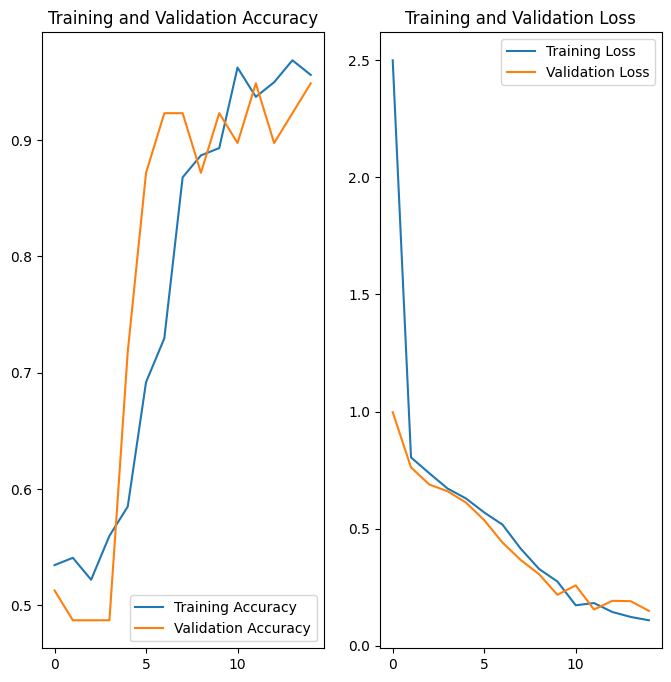

In [9]:
print_history(history)

## Text

### Load Dataset

In [10]:
data_dir:str = get_dataset_dir('data_multi_binary/train/text')

train_ds, val_ds = load_dataset(data_dir)
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

# Load datasets in cache to optimize 
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


### Model and Train

In [11]:
EPOCHS=15

with tf.device('/GPU:0'):
    # Def model
    model['text'] = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Feature extraction
        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        # Deep NN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Compile model
    model['text'].compile(optimizer='adamax', # or adam
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    # model.summary()

    checkpoint_filepath = '/tmp/checkpoint/text'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    history:tf.keras.callbacks.History = model['text'].fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=model_checkpoint_callback
    )

    model['text'].load_weights(checkpoint_filepath)

Epoch 1/15
3/3 [==============================] - 10s 3s/step - loss: 1.2792 - accuracy: 0.6125 - val_loss: 0.7588 - val_accuracy: 0.5000
Epoch 2/15
3/3 [==============================] - 8s 3s/step - loss: 0.9241 - accuracy: 0.4375 - val_loss: 0.7122 - val_accuracy: 0.5000
Epoch 3/15
3/3 [==============================] - 8s 3s/step - loss: 0.6770 - accuracy: 0.5375 - val_loss: 0.6749 - val_accuracy: 0.5000
Epoch 4/15
3/3 [==============================] - 9s 4s/step - loss: 0.6516 - accuracy: 0.5000 - val_loss: 0.6279 - val_accuracy: 0.5250
Epoch 5/15
3/3 [==============================] - 8s 2s/step - loss: 0.5893 - accuracy: 0.6062 - val_loss: 0.6150 - val_accuracy: 0.5250
Epoch 6/15
3/3 [==============================] - 9s 4s/step - loss: 0.5479 - accuracy: 0.6625 - val_loss: 0.5377 - val_accuracy: 0.6750
Epoch 7/15
3/3 [==============================] - 8s 3s/step - loss: 0.4928 - accuracy: 0.8625 - val_loss: 0.6027 - val_accuracy: 0.6500
Epoch 8/15
3/3 [========================

### Validate

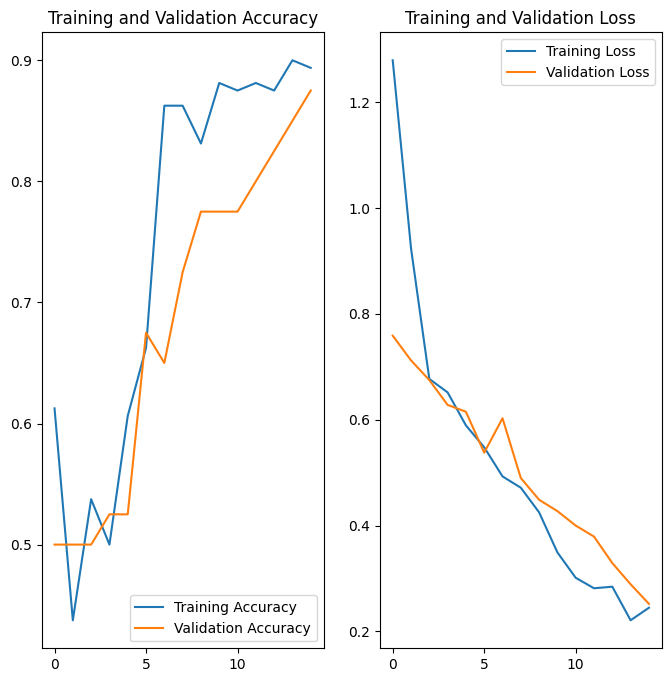

In [12]:
print_history(history)

## Schematics

### Load Dataset

In [13]:
data_dir:str = get_dataset_dir('data_multi_binary/train/schematics')

train_ds, val_ds = load_dataset(data_dir)
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

# Load datasets in cache to optimize 
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 273 files belonging to 2 classes.
Using 219 files for training.
Found 273 files belonging to 2 classes.
Using 54 files for validation.


### Model and Train

In [14]:
EPOCHS=15

with tf.device('/GPU:0'):
    # Def model
    model['schematics'] = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Feature extraction
        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        # Deep NN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Compile model
    model['schematics'].compile(optimizer='adamax', # or adam
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    # model.summary()
    checkpoint_filepath = '/tmp/checkpoint/schematics'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    history:tf.keras.callbacks.History = model['schematics'].fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=model_checkpoint_callback
    )
    model['schematics'].load_weights(checkpoint_filepath)

Epoch 1/15
4/4 [==============================] - 19s 5s/step - loss: 0.8842 - accuracy: 0.6027 - val_loss: 0.6037 - val_accuracy: 0.7222
Epoch 2/15
4/4 [==============================] - 11s 3s/step - loss: 0.7382 - accuracy: 0.5342 - val_loss: 0.6642 - val_accuracy: 0.7222
Epoch 3/15
4/4 [==============================] - 11s 3s/step - loss: 0.6778 - accuracy: 0.6119 - val_loss: 0.6276 - val_accuracy: 0.7222
Epoch 4/15
4/4 [==============================] - 12s 3s/step - loss: 0.6602 - accuracy: 0.6119 - val_loss: 0.6168 - val_accuracy: 0.7407
Epoch 5/15
4/4 [==============================] - 12s 3s/step - loss: 0.6390 - accuracy: 0.6347 - val_loss: 0.5737 - val_accuracy: 0.7407
Epoch 6/15
4/4 [==============================] - 12s 3s/step - loss: 0.6082 - accuracy: 0.6804 - val_loss: 0.5346 - val_accuracy: 0.7407
Epoch 7/15
4/4 [==============================] - 13s 3s/step - loss: 0.5687 - accuracy: 0.7032 - val_loss: 0.4977 - val_accuracy: 0.7778
Epoch 8/15
4/4 [==================

### Validate

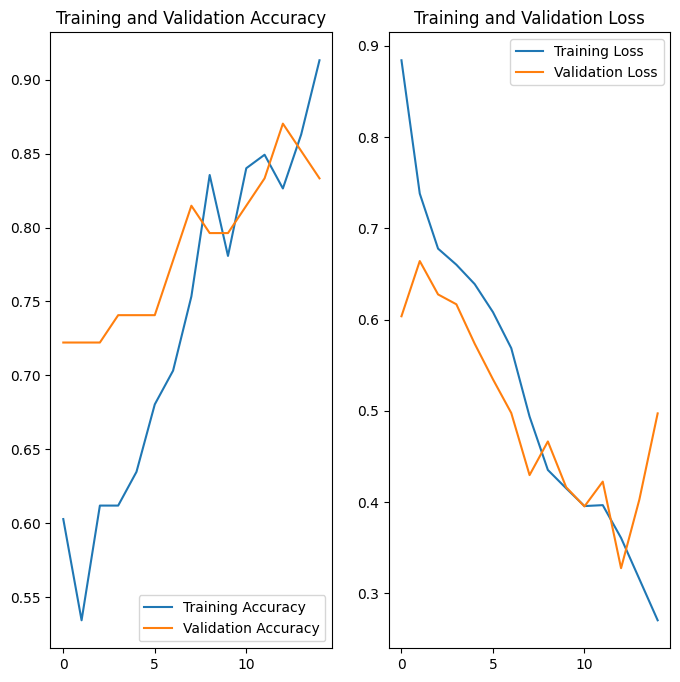

In [15]:
print_history(history)

## Painting

### Load Dataset

In [16]:
data_dir:str = get_dataset_dir('data_multi_binary/train/painting')

train_ds, val_ds = load_dataset(data_dir)
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

# Load datasets in cache to optimize 
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


### Model and Train

In [17]:
EPOCHS=15

with tf.device('/GPU:0'):
    # Def model
    model['painting'] = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Feature extraction
        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        # Deep NN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Compile model
    model['painting'].compile(optimizer='adamax', # or adam
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    # model.summary()

    checkpoint_filepath = '/tmp/checkpoint/painting'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    history:tf.keras.callbacks.History = model['painting'].fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=model_checkpoint_callback
    )
    model['painting'].load_weights(checkpoint_filepath)

Epoch 1/15
3/3 [==============================] - 10s 3s/step - loss: 1.7730 - accuracy: 0.4187 - val_loss: 0.8285 - val_accuracy: 0.5000
Epoch 2/15
3/3 [==============================] - 8s 3s/step - loss: 0.8290 - accuracy: 0.4812 - val_loss: 0.6826 - val_accuracy: 0.5000
Epoch 3/15
3/3 [==============================] - 9s 4s/step - loss: 0.6726 - accuracy: 0.6187 - val_loss: 0.6518 - val_accuracy: 0.8000
Epoch 4/15
3/3 [==============================] - 8s 3s/step - loss: 0.6355 - accuracy: 0.7500 - val_loss: 0.5812 - val_accuracy: 0.7750
Epoch 5/15
3/3 [==============================] - 8s 3s/step - loss: 0.5850 - accuracy: 0.7437 - val_loss: 0.5007 - val_accuracy: 0.7750
Epoch 6/15
3/3 [==============================] - 8s 3s/step - loss: 0.5310 - accuracy: 0.7688 - val_loss: 0.4050 - val_accuracy: 0.8000
Epoch 7/15
3/3 [==============================] - 8s 3s/step - loss: 0.4503 - accuracy: 0.8125 - val_loss: 0.3860 - val_accuracy: 0.8000
Epoch 8/15
3/3 [========================

### Validate

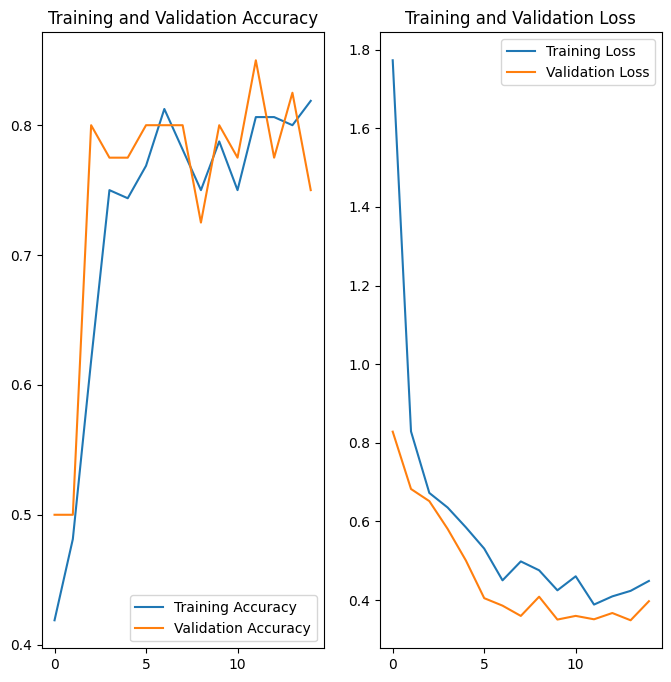

In [18]:
print_history(history)

## Photo

### Load Dataset

In [19]:
data_dir:str = get_dataset_dir('data_multi_binary/train/photo')

train_ds, val_ds = load_dataset(data_dir)
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

# Load datasets in cache to optimize 
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


### Model and Train

In [20]:
EPOCHS=15

with tf.device('/GPU:0'):
    # Def model
    model['photo'] = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Feature extraction
        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.MaxPooling2D(strides=2),

        # Deep NN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Compile model
    model['photo'].compile(optimizer='adamax', # or adam
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    # model.summary()
    checkpoint_filepath = '/tmp/checkpoint/photo'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    history:tf.keras.callbacks.History = model['photo'].fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=model_checkpoint_callback
    )
    model['photo'].load_weights(checkpoint_filepath)

Epoch 1/15
3/3 [==============================] - 10s 3s/step - loss: 1.1881 - accuracy: 0.5188 - val_loss: 0.7439 - val_accuracy: 0.5000
Epoch 2/15
3/3 [==============================] - 9s 4s/step - loss: 0.7596 - accuracy: 0.4750 - val_loss: 0.6709 - val_accuracy: 0.6000
Epoch 3/15
3/3 [==============================] - 8s 3s/step - loss: 0.6559 - accuracy: 0.7125 - val_loss: 0.6715 - val_accuracy: 0.6000
Epoch 4/15
3/3 [==============================] - 9s 3s/step - loss: 0.6508 - accuracy: 0.6187 - val_loss: 0.6343 - val_accuracy: 0.6250
Epoch 5/15
3/3 [==============================] - 10s 3s/step - loss: 0.5981 - accuracy: 0.6500 - val_loss: 0.5885 - val_accuracy: 0.7500
Epoch 6/15
3/3 [==============================] - 8s 3s/step - loss: 0.5292 - accuracy: 0.7500 - val_loss: 0.5868 - val_accuracy: 0.6750
Epoch 7/15
3/3 [==============================] - 8s 3s/step - loss: 0.5443 - accuracy: 0.7188 - val_loss: 0.5927 - val_accuracy: 0.7500
Epoch 8/15
3/3 [=======================

### Validate

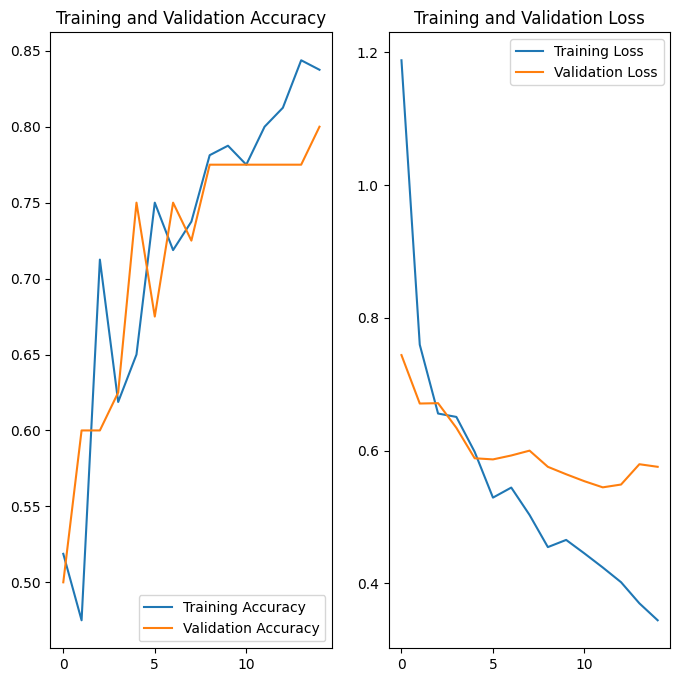

In [21]:
print_history(history)

## Test

In [22]:
test_images = tf.keras.utils.image_dataset_from_directory(
    'data_multi_binary/validation',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    # validation_split=VAL_SPLIT,
    # subset="training",
    # seed=123,
    #batch_size=BATCH_SIZE
)

class_names = test_images.class_names
print(class_names)
i = 0
error = 0

for b_images, b_labels in test_images.take(-1):
    predictions = model['text'].predict(b_images, verbose=0)
    
    for image, label, prediction in zip(b_images, b_labels, predictions) :
        print(class_names[label.numpy()],'text',int(np.round(prediction)))
        if not int(np.round(prediction)):

            batch_img = tf.expand_dims(image, 0)
            predictions = model['sketch'].predict(batch_img, verbose=0)
                
            print(class_names[label.numpy()],'sketch',int(np.round(predictions[0])))
            if not int(np.round(predictions[0])):
                predictions = model['schematics'].predict(batch_img, verbose=0)
                print(class_names[label.numpy()],'schematics',int(np.round(predictions[0])))
                if not int(np.round(predictions[0])):
                    predictions = model['painting'].predict(batch_img, verbose=0)
                    print(class_names[label.numpy()],'painting',int(np.round(predictions[0])))
                    if not int(np.round(predictions[0])):
                        predictions = model['photo'].predict(batch_img, verbose=0)
                        print(class_names[label.numpy()],'photo',int(np.round(predictions[0])))
                        if not int(np.round(predictions[0])):
                            print('isPhoto')
                            if class_names[label.numpy()] == 'photo':
                                print('error is photo')
                                error += 1

                        else:
                            if class_names[label.numpy()] != 'photo':
                                print('error is not photo')
                                error += 1

                    else:
                        if class_names[label.numpy()] != 'painting':
                            print('error is not painting')
                            error += 1

                else:
                    if class_names[label.numpy()] != 'schematics':
                        print('error is not schematics')
                        error += 1

            else:
                if class_names[label.numpy()] != 'sketch':
                    print('error is not sketch')
                    error += 1

        else:
            if class_names[label.numpy()] != 'text':
                print('error is not text')
                error += 1
            # plt.figure(figsize=(6,3))
            # plt.imshow(image.numpy().astype("uint8"))
            # plt.xlabel("Pred:{} {:2.0f}% (True:{})".format(class_names[int(np.round(prediction))], 100*np.max(predictions), class_names[label.numpy()]),color='red')

        i += 1
        print('next')
        

print(f"Number error: {error} on {i} images")
print(f"{error/i*100}% error")

Found 268 files belonging to 5 classes.
['painting', 'photo', 'schematics', 'sketch', 'text']
text text 1
next
photo text 0
photo sketch 0
photo schematics 1
error is not schematics
next
photo text 0
photo sketch 0
photo schematics 1
error is not schematics
next
sketch text 0
sketch sketch 0
sketch schematics 0
sketch painting 0
sketch photo 0
isPhoto
next
photo text 0
photo sketch 0
photo schematics 0
photo painting 0
photo photo 1
next
schematics text 0
schematics sketch 0
schematics schematics 1
next
text text 1
next
photo text 0
photo sketch 0
photo schematics 0
photo painting 1
error is not painting
next
schematics text 0
schematics sketch 0
schematics schematics 1
next
photo text 0
photo sketch 0
photo schematics 1
error is not schematics
next
schematics text 0
schematics sketch 0
schematics schematics 1
next
painting text 0
painting sketch 0
painting schematics 0
painting painting 1
next
schematics text 0
schematics sketch 0
schematics schematics 0
schematics painting 0
schemati

In [39]:
test_images = tf.keras.utils.image_dataset_from_directory(
    'data_multi_binary/validation',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    # validation_split=VAL_SPLIT,
    # subset="training",
    # seed=123,
    #batch_size=BATCH_SIZE
)

class_names = test_images.class_names
print(class_names)
i = 0
error = 0
notsure = 0

for b_images, b_labels in test_images.take(-1):
    prediction1 = model['painting'].predict(b_images, verbose=0)
    prediction2 = model['photo'].predict(b_images, verbose=0)
    prediction3 = model['schematics'].predict(b_images, verbose=0)
    prediction4 = model['sketch'].predict(b_images, verbose=0)
    prediction5 = model['text'].predict(b_images, verbose=0)

    for image, label, prediction in zip(b_images, b_labels, zip(prediction1,prediction2,prediction3,prediction4,prediction5)) :
        
        result = {}
        find = 0
        great = 0
        notsure_error = 0

        n = 0
        for pred in prediction:
            result[class_names[n]] = pred[0]
            if int(np.round(pred)):
                find += 1
                great = 0
                if class_names[label.numpy()] == class_names[n]:
                    great = 1
            n+=1

        if not great:
            print(class_names[label.numpy()],find,result)
            if find != 1:
                notsure += 1
                if find > 1:
                    if class_names[label.numpy()] != max(result, key=result.get):
                        notsure_error += 1
            else:
                error += 1

        i += 1
        

print(f"Number error: {error} on {i} images")
print(f"{error/i*100}% error")
print(f"Number not sure: {notsure} on {i} images")
print(f"{notsure/i*100}% not sure")
print(f"Number not sure and false: {notsure_error} on {i} images")
print(f"{notsure_error/i*100}% not sure and false")

Found 268 files belonging to 5 classes.
['painting', 'photo', 'schematics', 'sketch', 'text']
sketch 3 {'schematics': 0.5603287, 'sketch': 0.68558365, 'text': 0.52844554}
sketch 0 {}
sketch 2 {'schematics': 0.72999156, 'text': 0.55513984}
painting 0 {}
photo 3 {'painting': 0.66712177, 'photo': 0.78059345, 'schematics': 0.8953675}
photo 2 {'photo': 0.78402007, 'schematics': 0.7177015}
schematics 0 {}
sketch 1 {'schematics': 0.79257786}
schematics 0 {}
photo 1 {'painting': 0.63281447}
photo 2 {'photo': 0.579547, 'schematics': 0.7066271}
painting 2 {'schematics': 0.8161196, 'text': 0.50652283}
schematics 1 {'text': 0.55419827}
sketch 1 {'schematics': 0.506819}
sketch 0 {}
photo 3 {'painting': 0.8635044, 'photo': 0.9384874, 'schematics': 0.9000159}
schematics 0 {}
sketch 0 {}
sketch 1 {'schematics': 0.5221767}
sketch 0 {}
sketch 1 {'schematics': 0.6156299}
painting 2 {'painting': 0.9551337, 'photo': 0.72626805}
painting 2 {'painting': 0.96555096, 'photo': 0.9754478}
photo 3 {'painting': 0.